CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla T4

🔧 Training Configuration:
   • Dataset: UCI-HAR (9 sensor channels)
   • Label Ratio: 0.2 (20.0% labeled)
   • Learning Rate: 0.0001
   • Batch Size: 32
   • Alpha (loss weight): 1.0
   • Epochs: 50
   • Patience: 15
Loading UCI HAR data from: /content/drive/MyDrive/UCI_HAR_Dataset
  Loaded body_acc_x: shape=(10299, 128)
  Loaded body_acc_y: shape=(10299, 128)
  Loaded body_acc_z: shape=(10299, 128)
  Loaded body_gyro_x: shape=(10299, 128)
  Loaded body_gyro_y: shape=(10299, 128)
  Loaded body_gyro_z: shape=(10299, 128)
  Loaded total_acc_x: shape=(10299, 128)
  Loaded total_acc_y: shape=(10299, 128)
  Loaded total_acc_z: shape=(10299, 128)
Stacked signals shape: (10299, 128, 9)
Transposed X shape (N, C, L): (10299, 9, 128)
Loaded labels shape: (10299,)
Unique labels: [0 1 2 3 4 5]

✅ Data loading successful.
Input Channels: 9, Sequence Length: 128, Num Classes: 6
Class Names: ['Walking', 'Walk

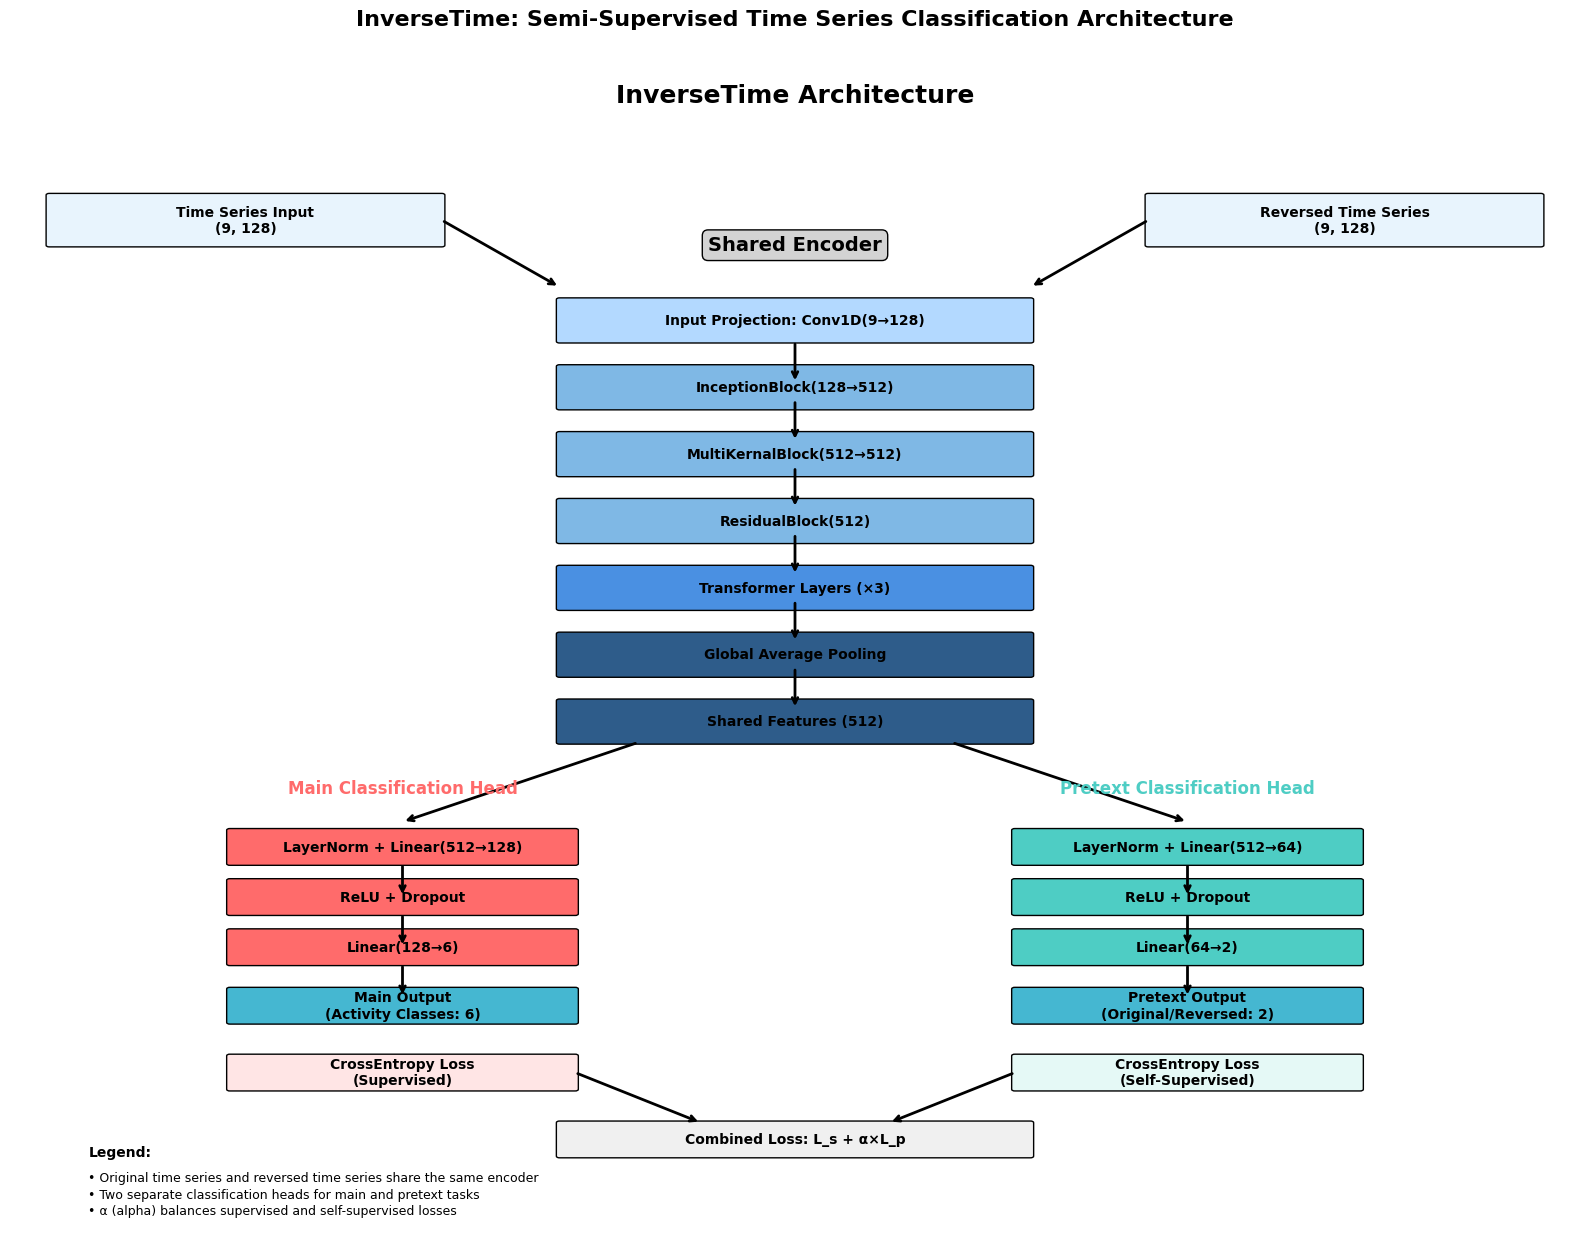


3. Training Flow Diagram:


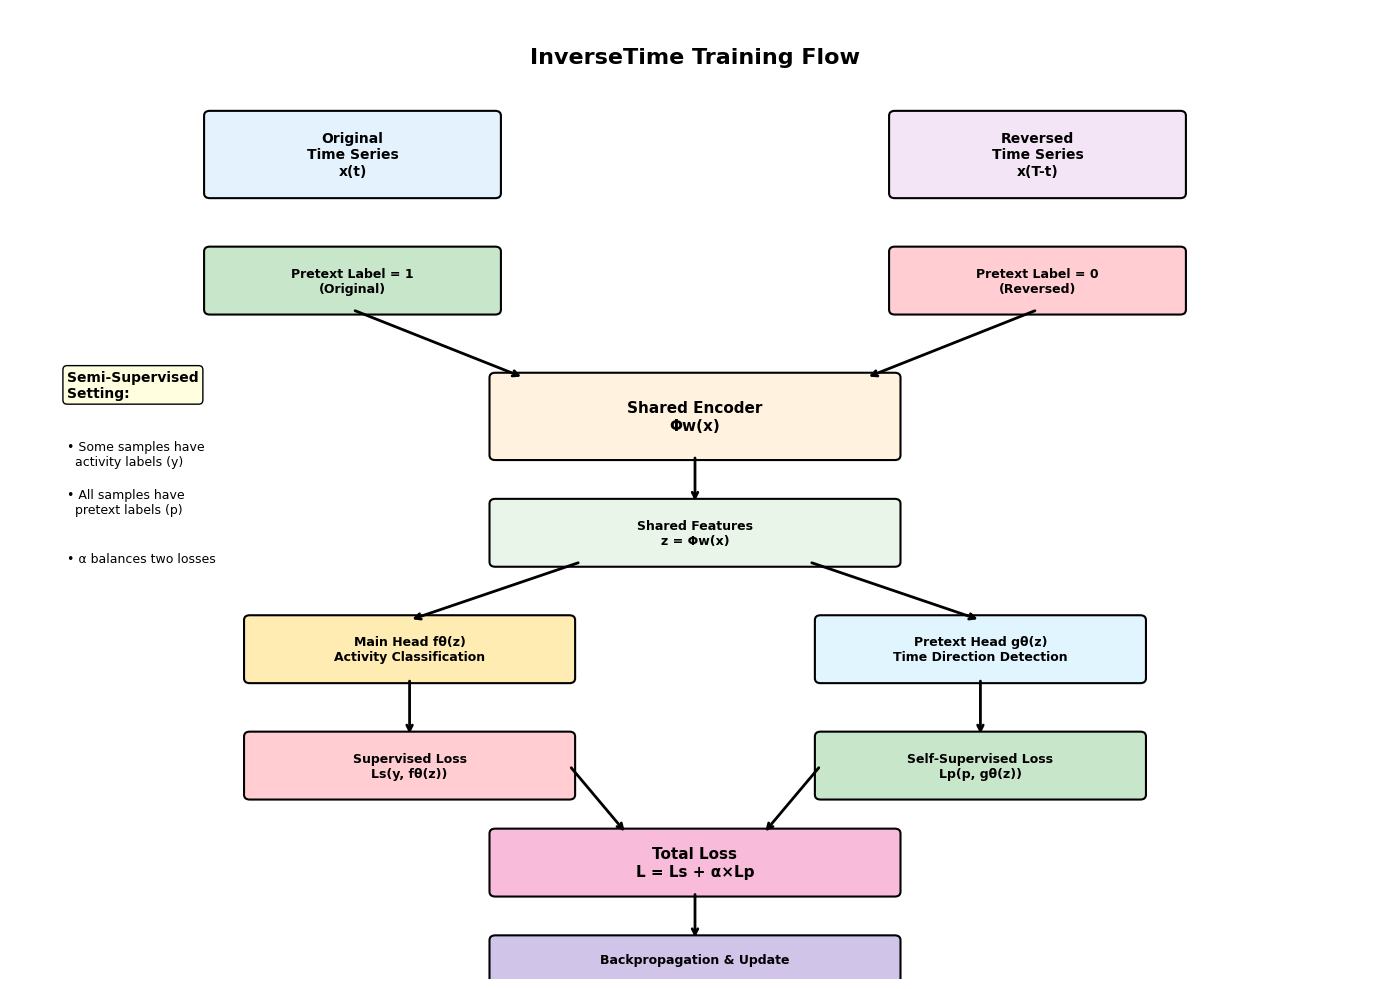


4. Data Augmentation Strategy:


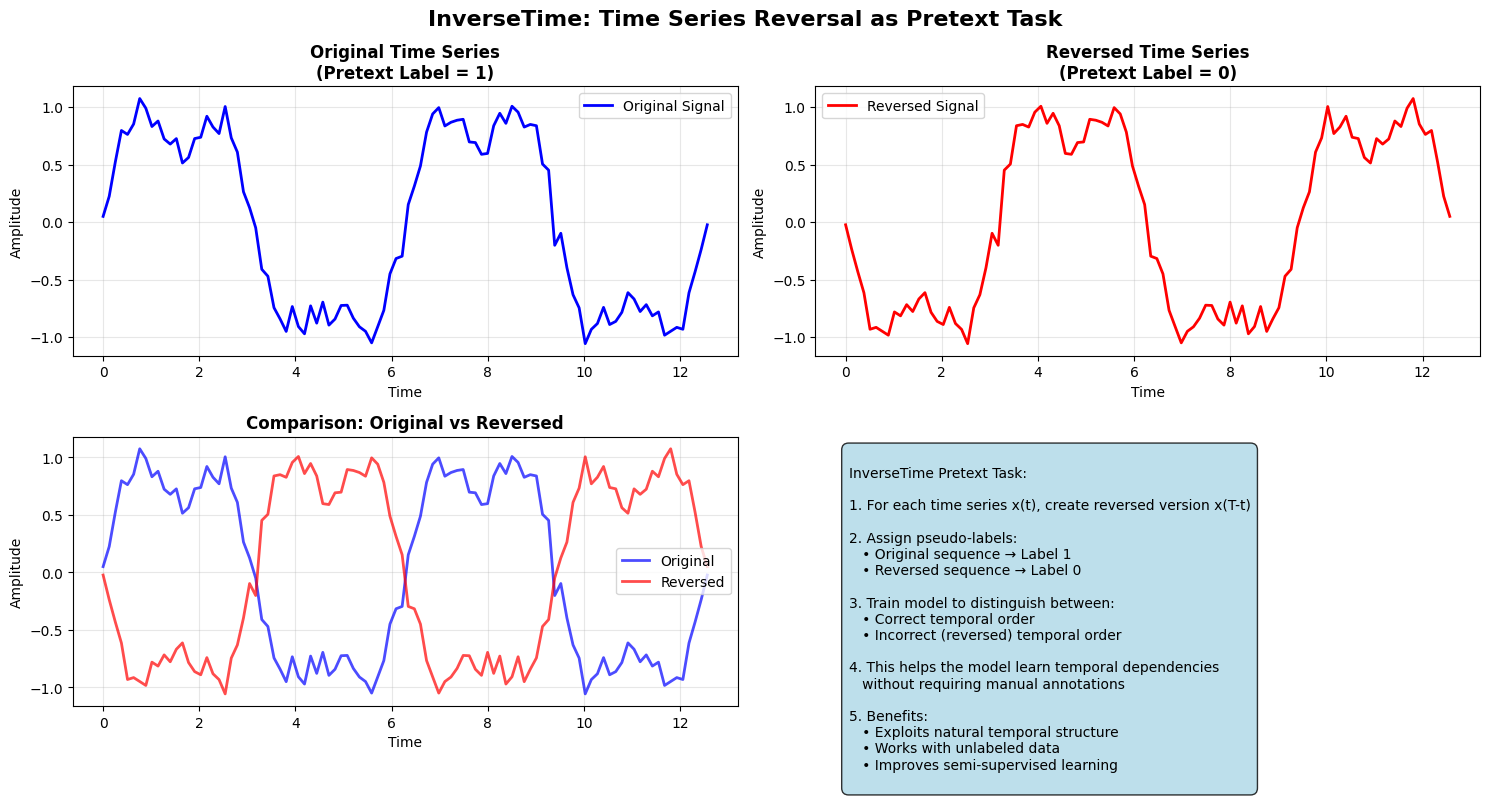


5. Architecture Comparison:


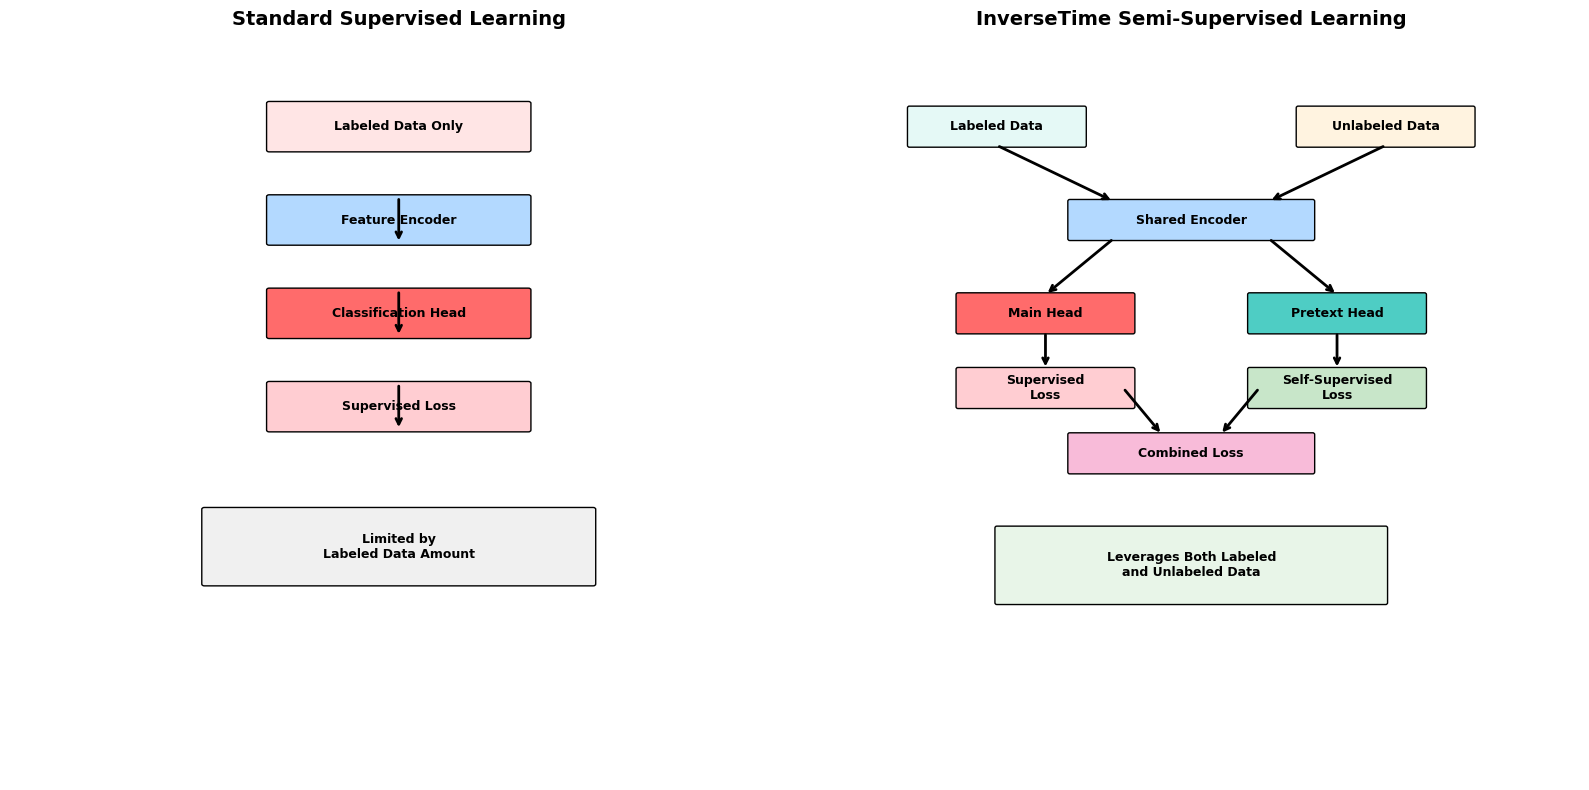


Model architecture visualization complete!

=== InverseTime Model Training Started (Device: cuda) ===
Using alpha=1.0 for loss weighting
Model device confirmed: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
  Train - Total: 0.9330, Main: 0.4379, Pretext: 0.4950, Acc: 0.8413
  Val   - Total: 0.4863, Acc: 0.9214
Epoch 2/50
  Train - Total: 0.6636, Main: 0.2762, Pretext: 0.3874, Acc: 0.9255
  Val   - Total: 0.4740, Acc: 0.9311
Epoch 3/50
  Train - Total: 0.5574, Main: 0.1995, Pretext: 0.3579, Acc: 0.9409
  Val   - Total: 0.4050, Acc: 0.9515
Epoch 4/50
  Train - Total: 0.4641, Main: 0.1657, Pretext: 0.2984, Acc: 0.9401
  Val   - Total: 0.3825, Acc: 0.9481
Epoch 5/50
  Train - Total: 0.5015, Main: 0.2372, Pretext: 0.2643, Acc: 0.9247
  Val   - Total: 0.3608, Acc: 0.9451
Epoch 6/50
  Train - Total: 0.4079, Main: 0.1717, Pretext: 0.2363, Acc: 0.9352
  Val   - Total: 0.3165, Acc: 0.9544
Epoch 7/50
  Train - Total: 0.3771, Main: 0.1655, Pretext: 0.2116, Acc: 0.9474
  Val   - Total: 0.3611, Acc: 0.9350
Epoch 8/50
  Train - Total: 0.3562, Main: 0.1624, Pretext: 0.1938, Acc: 0.9498
  Val   - Total: 0.2720, Acc: 0.9466
Epoch 9/50
  Train - Total: 0.2576, Main: 0.1418, Pretext: 0.1157, Acc: 

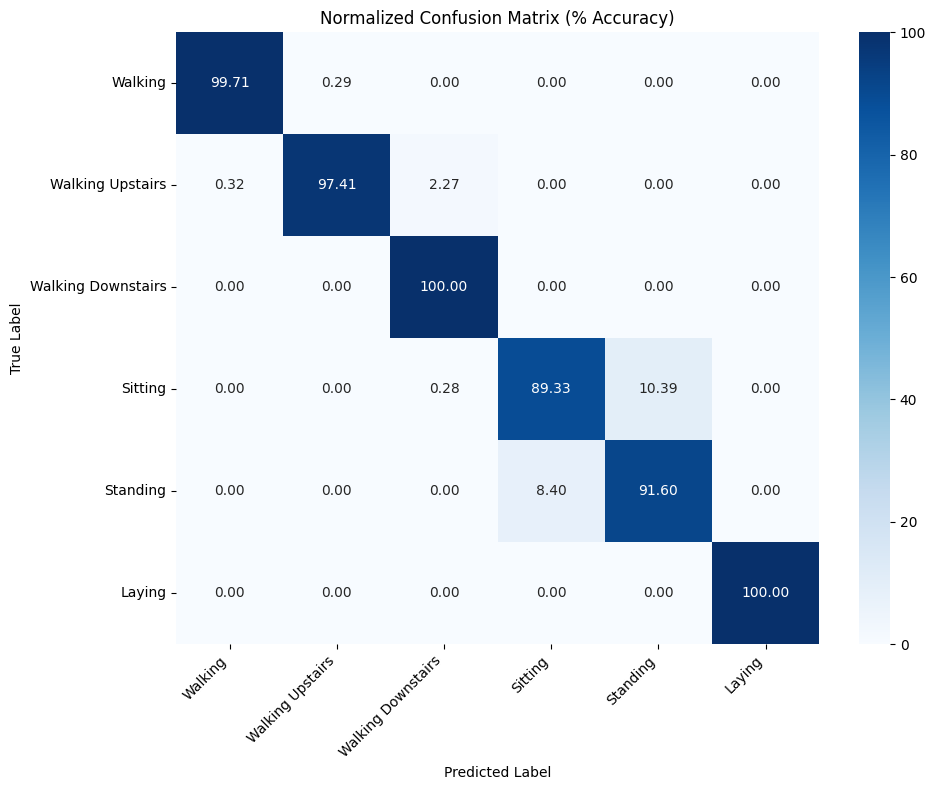

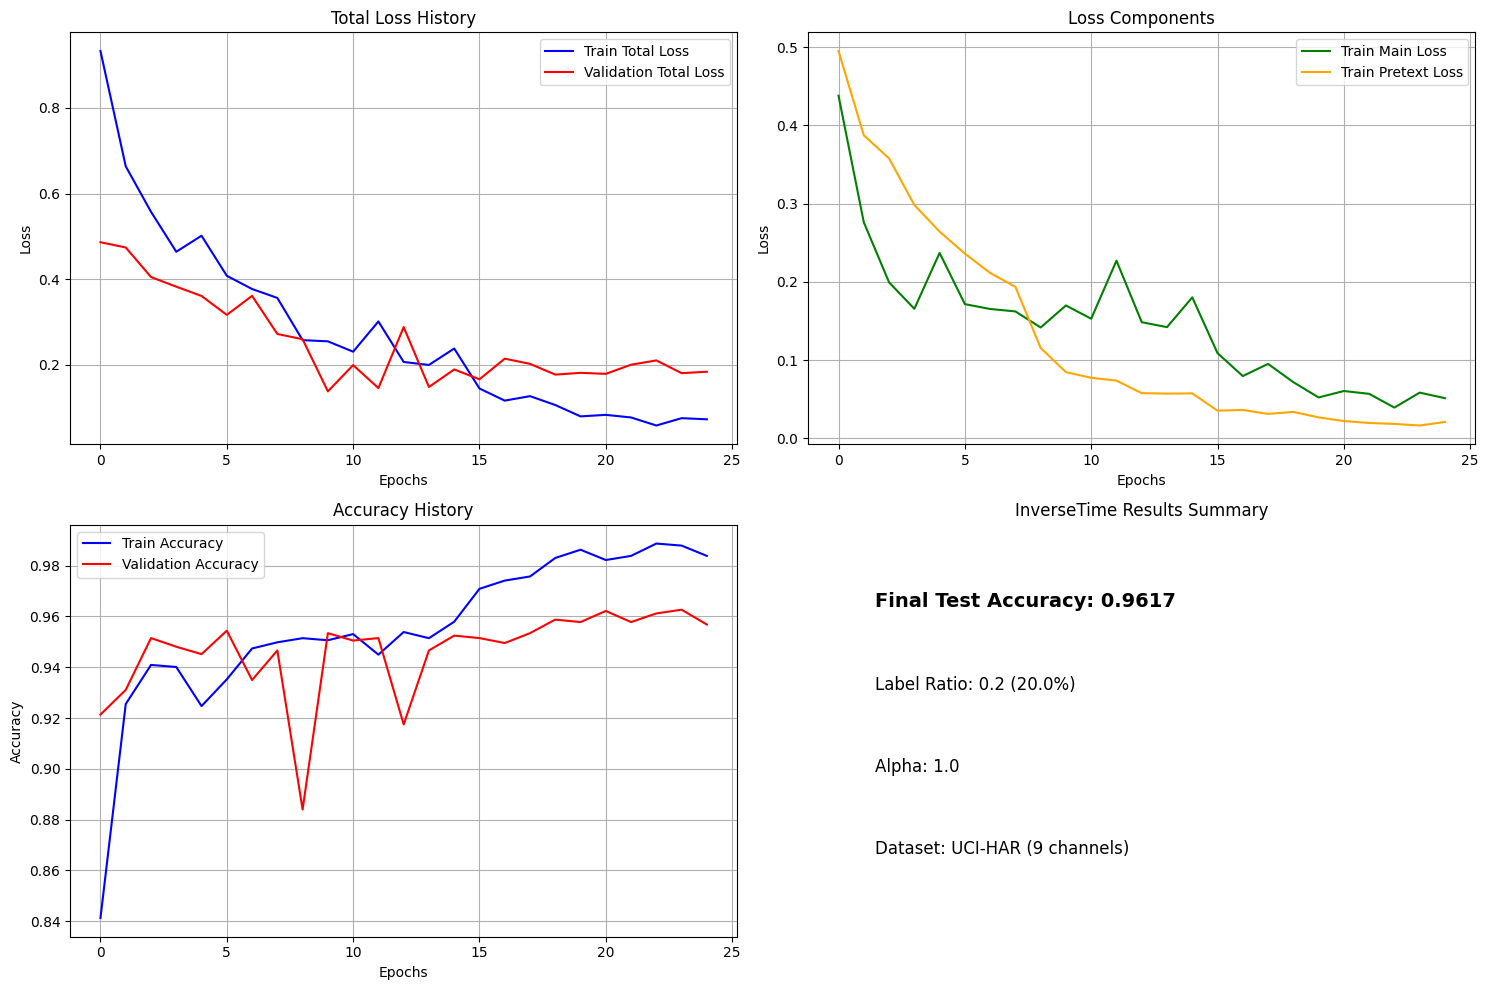

Semi-supervised setting: 20.0% labeled data

Model Architecture Summary:
   • Total Parameters: 11,686,472
   • Shared Encoder: 9 → 512 features
   • Main Head: 512 → 6 classes
   • Pretext Head: 512 → 2 classes
   • Loss Weight α: 1.0
   • Trainable Parameters: 11,686,472
   • Model Size: 44.58 MB (float32)
   • Sensor Channels: 9 (body_acc_x/y/z, body_gyro_x/y/z, total_acc_x/y/z)


In [2]:
#!/usr/bin/env python
# coding: utf-8

# InverseTime Semi-Supervised Learning applied to UCI-HAR Dataset
# Based on: InverseTime: A Self-Supervised Technique for Semi-Supervised Classification of Time Series

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For model architecture visualization
try:
    from torchinfo import summary
    TORCHINFO_AVAILABLE = True
except ImportError:
    TORCHINFO_AVAILABLE = False
    print("Warning: torchinfo not available. Install with 'pip install torchinfo' for detailed model summary.")

try:
    import graphviz
    GRAPHVIZ_AVAILABLE = True
except ImportError:
    GRAPHVIZ_AVAILABLE = False
    print("Warning: graphviz not available. Install with 'pip install graphviz' for architecture diagrams.")

import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch


# ---------------- Depthwise Separable Conv ----------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                        padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

# ---------------- MultiKernalBlock ----------------
class MultiKernalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip_proj = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn_skip = nn.BatchNorm1d(out_channels * 4)
        self.branch7 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=7, padding=3)
        self.branch5 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1)
        self.branch1 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x))
        x7 = self.branch7(x)
        x5 = self.branch5(x7)
        x3 = self.branch3(x5)
        x1 = self.branch1(x3)
        out = torch.cat([x1, x3, x5, x7], dim=1)
        out = out + identity
        return F.relu(out)

# ---------------- InceptionBlock ----------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_per_branch):
        super().__init__()
        total_out_channels = out_channels_per_branch * 4
        self.skip_proj = nn.Conv1d(in_channels, total_out_channels, kernel_size=1, bias=False)
        self.bn_skip = nn.BatchNorm1d(total_out_channels)
        self.branch1 = DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        self.branch3 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=3, padding=1)
        )
        self.branch5 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=5, padding=2)
        )
        self.pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        )
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x))
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.pool(x)
        out = torch.cat([b1, b3, b5, bp], dim=1)
        out = out + identity
        return F.relu(out)

# ---------------- ResidualBlock----------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return self.relu(out)

# ---------------- TransformerEncoderBlock ----------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4), nn.ReLU(), nn.Dropout(dropout), nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_norm1 = self.norm1(x)
        attn_out, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout(attn_out)
        x_norm2 = self.norm2(x)
        ffn_out = self.ffn(x_norm2)
        x = x + self.dropout(ffn_out)
        return x

# ---------------- InverseTime InceptionFormer ----------------
class InverseTimeInceptionFormer(nn.Module):
    """InceptionFormer with InverseTime pretext task for semi-supervised learning"""
    def __init__(self, input_channels=9, feature_dim=64, num_classes=6, num_transformer_layers=2, num_heads=4, dropout=0.1):
        super().__init__()
        # Shared encoder
        self.input_proj = nn.Conv1d(input_channels, feature_dim, kernel_size=1, bias=False)
        self.input_bn = nn.BatchNorm1d(feature_dim)
        self.inception = InceptionBlock(feature_dim, feature_dim)
        self.mkls = MultiKernalBlock(feature_dim * 4, feature_dim)
        self.residual1 = ResidualBlock(feature_dim * 4)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(dim=feature_dim * 4, num_heads=num_heads, dropout=dropout)
            for _ in range(num_transformer_layers)
        ])
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()

        # Main classification head (f_θ)
        self.main_classifier = nn.Sequential(
            nn.LayerNorm(feature_dim * 4),
            nn.Linear(feature_dim * 4, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

        # Pretext task head (g_θ) for InverseTime
        self.pretext_classifier = nn.Sequential(
            nn.LayerNorm(feature_dim * 4),
            nn.Linear(feature_dim * 4, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)  # Binary classification: 0=reversed, 1=original
        )

    def forward(self, x):
        # Shared feature extraction
        x = F.relu(self.input_bn(self.input_proj(x)))
        x = self.inception(x)
        x = self.mkls(x)
        x = self.residual1(x)
        x = x.permute(0, 2, 1)
        for layer in self.transformer_layers:
            x = layer(x)
        x = x.permute(0, 2, 1)
        x = self.gap(x)
        features = self.flatten(x)

        # Two prediction heads
        main_output = self.main_classifier(features)
        pretext_output = self.pretext_classifier(features)

        return main_output, pretext_output


# ==============================================================================
# Model Architecture Visualization Functions
# ==============================================================================

def visualize_inversetime_architecture(input_channels=9, sequence_length=128, feature_dim=128, num_classes=6):
    """
    Creates a visual representation of the InverseTime architecture similar to Keras plot_model
    """
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 14)
    ax.axis('off')

    # Color scheme
    colors = {
        'input': '#E8F4FD',
        'conv': '#B3D9FF',
        'inception': '#7FB8E5',
        'transformer': '#4A90E2',
        'shared': '#2E5C8A',
        'main_head': '#FF6B6B',
        'pretext_head': '#4ECDC4',
        'output': '#45B7D1'
    }

    # Helper function to draw boxes
    def draw_box(x, y, width, height, text, color, fontsize=10):
        box = FancyBboxPatch(
            (x-width/2, y-height/2), width, height,
            boxstyle="round,pad=0.02",
            facecolor=color,
            edgecolor='black',
            linewidth=1
        )
        ax.add_patch(box)
        ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, weight='bold')

    # Helper function to draw arrows
    def draw_arrow(start_x, start_y, end_x, end_y, color='black', style='-'):
        ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                   arrowprops=dict(arrowstyle='->', color=color, lw=2, linestyle=style))

    # Title
    ax.text(5, 13.5, 'InverseTime Architecture', ha='center', va='center',
            fontsize=18, weight='bold')

    # Input layers
    draw_box(1.5, 12, 2.5, 0.6, f'Time Series Input\n({input_channels}, {sequence_length})', colors['input'])
    draw_box(8.5, 12, 2.5, 0.6, f'Reversed Time Series\n({input_channels}, {sequence_length})', colors['input'])

    # Arrows from inputs to shared encoder
    draw_arrow(2.75, 12, 3.5, 11.2)
    draw_arrow(7.25, 12, 6.5, 11.2)

    # Shared Encoder Title
    ax.text(5, 11.7, 'Shared Encoder', ha='center', va='center',
            fontsize=14, weight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray'))

    # Shared encoder components
    draw_box(5, 10.8, 3, 0.5, f'Input Projection: Conv1D({input_channels}→{feature_dim})', colors['conv'])
    draw_box(5, 10.0, 3, 0.5, f'InceptionBlock({feature_dim}→{feature_dim*4})', colors['inception'])
    draw_box(5, 9.2, 3, 0.5, f'MultiKernalBlock({feature_dim*4}→{feature_dim*4})', colors['inception'])
    draw_box(5, 8.4, 3, 0.5, f'ResidualBlock({feature_dim*4})', colors['inception'])
    draw_box(5, 7.6, 3, 0.5, f'Transformer Layers (×3)', colors['transformer'])
    draw_box(5, 6.8, 3, 0.5, f'Global Average Pooling', colors['shared'])
    draw_box(5, 6.0, 3, 0.5, f'Shared Features ({feature_dim*4})', colors['shared'])

    # Arrows in shared encoder
    for y in [10.3, 9.6, 8.8, 8.0, 7.2, 6.4]:
        draw_arrow(5, y+0.25, 5, y-0.25)

    # Split to two heads
    draw_arrow(4, 5.75, 2.5, 4.8)
    draw_arrow(6, 5.75, 7.5, 4.8)

    # Main Classification Head
    ax.text(2.5, 5.2, 'Main Classification Head', ha='center', va='center',
            fontsize=12, weight='bold', color=colors['main_head'])
    draw_box(2.5, 4.5, 2.2, 0.4, f'LayerNorm + Linear({feature_dim*4}→128)', colors['main_head'])
    draw_box(2.5, 3.9, 2.2, 0.4, 'ReLU + Dropout', colors['main_head'])
    draw_box(2.5, 3.3, 2.2, 0.4, f'Linear(128→{num_classes})', colors['main_head'])
    draw_box(2.5, 2.6, 2.2, 0.4, f'Main Output\n(Activity Classes: {num_classes})', colors['output'])

    # Pretext Classification Head
    ax.text(7.5, 5.2, 'Pretext Classification Head', ha='center', va='center',
            fontsize=12, weight='bold', color=colors['pretext_head'])
    draw_box(7.5, 4.5, 2.2, 0.4, f'LayerNorm + Linear({feature_dim*4}→64)', colors['pretext_head'])
    draw_box(7.5, 3.9, 2.2, 0.4, 'ReLU + Dropout', colors['pretext_head'])
    draw_box(7.5, 3.3, 2.2, 0.4, 'Linear(64→2)', colors['pretext_head'])
    draw_box(7.5, 2.6, 2.2, 0.4, 'Pretext Output\n(Original/Reversed: 2)', colors['output'])

    # Arrows in heads
    for x in [2.5, 7.5]:
        for y in [4.1, 3.5, 2.9]:
            draw_arrow(x, y+0.2, x, y-0.2)

    # Loss functions
    draw_box(2.5, 1.8, 2.2, 0.4, 'CrossEntropy Loss\n(Supervised)', '#FFE5E5')
    draw_box(7.5, 1.8, 2.2, 0.4, 'CrossEntropy Loss\n(Self-Supervised)', '#E5F9F6')

    # Final combined loss
    draw_arrow(3.6, 1.8, 4.4, 1.2)
    draw_arrow(6.4, 1.8, 5.6, 1.2)
    draw_box(5, 1.0, 3, 0.4, 'Combined Loss: L_s + α×L_p', '#F0F0F0')

    # Legend
    legend_x, legend_y = 0.5, 0.5
    ax.text(legend_x, legend_y + 0.3, 'Legend:', fontsize=10, weight='bold')
    ax.text(legend_x, legend_y, '• Original time series and reversed time series share the same encoder', fontsize=9)
    ax.text(legend_x, legend_y - 0.2, '• Two separate classification heads for main and pretext tasks', fontsize=9)
    ax.text(legend_x, legend_y - 0.4, '• α (alpha) balances supervised and self-supervised losses', fontsize=9)

    plt.tight_layout()
    plt.title('InverseTime: Semi-Supervised Time Series Classification Architecture', pad=20, fontsize=16, weight='bold')
    plt.show()


def show_model_summary(model, input_shape=(1, 9, 128), device='cpu'):
    """
    Show detailed model summary using torchinfo (similar to Keras model.summary())
    """
    if not TORCHINFO_AVAILABLE:
        print("torchinfo is not available. Please install it with: pip install torchinfo")
        return

    print("="*80)
    print("INVERSETIME MODEL SUMMARY")
    print("="*80)

    # Move model to specified device temporarily for summary
    original_device = next(model.parameters()).device
    if device != str(original_device):
        model_copy = model.to(device)
    else:
        model_copy = model

    try:
        # Create summary
        model_summary = summary(
            model_copy,
            input_size=input_shape,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            device=device,
            verbose=0
        )

        print(model_summary)

        # Additional information
        total_params = sum(p.numel() for p in model_copy.parameters())
        trainable_params = sum(p.numel() for p in model_copy.parameters() if p.requires_grad)

        print("\n" + "="*80)
        print("ADDITIONAL MODEL INFORMATION")
        print("="*80)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Non-trainable parameters: {total_params - trainable_params:,}")
        print(f"Model size (MB): {total_params * 4 / (1024**2):.2f}")  # Assuming float32

        # Architecture details
        print(f"\nArchitecture Details:")
        print(f"• Shared Encoder: Input→Features")
        print(f"• Main Classification Head: Features→{model_copy.main_classifier[-1].out_features} classes")
        print(f"• Pretext Classification Head: Features→2 classes (Original/Reversed)")
        print(f"• Input Shape: {input_shape}")

    except Exception as e:
        print(f"Error generating model summary: {e}")
        print("Falling back to basic parameter count...")
        total_params = sum(p.numel() for p in model_copy.parameters())
        print(f"Total parameters: {total_params:,}")

    finally:
        # Move model back to original device if we moved it
        if device != str(original_device):
            model.to(original_device)


def create_architecture_flow_diagram():
    """
    Creates a flow diagram showing the InverseTime training process
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Title
    ax.text(6, 9.5, 'InverseTime Training Flow', ha='center', va='center',
            fontsize=16, weight='bold')

    # Helper function to draw boxes
    def draw_flow_box(x, y, width, height, text, color, fontsize=9):
        box = FancyBboxPatch(
            (x-width/2, y-height/2), width, height,
            boxstyle="round,pad=0.05",
            facecolor=color,
            edgecolor='black',
            linewidth=1.5
        )
        ax.add_patch(box)
        ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, weight='bold')

    # Helper function to draw arrows
    def draw_flow_arrow(start_x, start_y, end_x, end_y, color='black', style='-', width=2):
        ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                   arrowprops=dict(arrowstyle='->', color=color, lw=width, linestyle=style))

    # Step 1: Data preparation
    draw_flow_box(3, 8.5, 2.5, 0.8, 'Original\nTime Series\nx(t)', '#E3F2FD', 10)
    draw_flow_box(9, 8.5, 2.5, 0.8, 'Reversed\nTime Series\nx(T-t)', '#F3E5F5', 10)

    # Step 2: Label assignment
    draw_flow_box(3, 7.2, 2.5, 0.6, 'Pretext Label = 1\n(Original)', '#C8E6C9')
    draw_flow_box(9, 7.2, 2.5, 0.6, 'Pretext Label = 0\n(Reversed)', '#FFCDD2')

    # Arrows to encoder
    draw_flow_arrow(3, 6.9, 4.5, 6.2)
    draw_flow_arrow(9, 6.9, 7.5, 6.2)

    # Step 3: Shared encoder
    draw_flow_box(6, 5.8, 3.5, 0.8, 'Shared Encoder\nΦw(x)', '#FFF3E0', 11)

    # Step 4: Feature extraction
    draw_flow_box(6, 4.6, 3.5, 0.6, 'Shared Features\nz = Φw(x)', '#E8F5E8')
    draw_flow_arrow(6, 5.4, 6, 4.9)

    # Step 5: Dual heads
    draw_flow_arrow(5, 4.3, 3.5, 3.7)
    draw_flow_arrow(7, 4.3, 8.5, 3.7)

    draw_flow_box(3.5, 3.4, 2.8, 0.6, 'Main Head fθ(z)\nActivity Classification', '#FFECB3')
    draw_flow_box(8.5, 3.4, 2.8, 0.6, 'Pretext Head gθ(z)\nTime Direction Detection', '#E1F5FE')

    # Step 6: Loss computation
    draw_flow_box(3.5, 2.2, 2.8, 0.6, 'Supervised Loss\nLs(y, fθ(z))', '#FFCDD2')
    draw_flow_box(8.5, 2.2, 2.8, 0.6, 'Self-Supervised Loss\nLp(p, gθ(z))', '#C8E6C9')

    draw_flow_arrow(3.5, 3.1, 3.5, 2.5)
    draw_flow_arrow(8.5, 3.1, 8.5, 2.5)

    # Step 7: Combined loss
    draw_flow_arrow(4.9, 2.2, 5.4, 1.5)
    draw_flow_arrow(7.1, 2.2, 6.6, 1.5)

    draw_flow_box(6, 1.2, 3.5, 0.6, 'Total Loss\nL = Ls + α×Lp', '#F8BBD9', 11)

    # Step 8: Backpropagation
    draw_flow_arrow(6, 0.9, 6, 0.4)
    draw_flow_box(6, 0.2, 3.5, 0.4, 'Backpropagation & Update', '#D1C4E9')

    # Add annotations
    ax.text(0.5, 6, 'Semi-Supervised\nSetting:', fontsize=10, weight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow'))
    ax.text(0.5, 5.3, '• Some samples have\n  activity labels (y)', fontsize=9)
    ax.text(0.5, 4.8, '• All samples have\n  pretext labels (p)', fontsize=9)
    ax.text(0.5, 4.3, '• α balances two losses', fontsize=9)

    plt.tight_layout()
    plt.show()


def visualize_data_augmentation():
    """
    Visualizes the InverseTime data augmentation strategy
    """
    # Create sample time series data for visualization
    t = np.linspace(0, 4*np.pi, 100)
    original_signal = np.sin(t) + 0.3*np.sin(3*t) + 0.1*np.random.randn(100)
    reversed_signal = original_signal[::-1]

    fig, axes = plt.subplots(2, 2, figsize=(15, 8))

    # Original time series
    axes[0, 0].plot(t, original_signal, 'b-', linewidth=2, label='Original Signal')
    axes[0, 0].set_title('Original Time Series\n(Pretext Label = 1)', fontsize=12, weight='bold')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()

    # Reversed time series
    axes[0, 1].plot(t, reversed_signal, 'r-', linewidth=2, label='Reversed Signal')
    axes[0, 1].set_title('Reversed Time Series\n(Pretext Label = 0)', fontsize=12, weight='bold')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Amplitude')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # Comparison
    axes[1, 0].plot(t, original_signal, 'b-', linewidth=2, label='Original', alpha=0.7)
    axes[1, 0].plot(t, reversed_signal, 'r-', linewidth=2, label='Reversed', alpha=0.7)
    axes[1, 0].set_title('Comparison: Original vs Reversed', fontsize=12, weight='bold')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    # InverseTime concept explanation
    axes[1, 1].axis('off')
    explanation_text = """
InverseTime Pretext Task:

1. For each time series x(t), create reversed version x(T-t)

2. Assign pseudo-labels:
   • Original sequence → Label 1
   • Reversed sequence → Label 0

3. Train model to distinguish between:
   • Correct temporal order
   • Incorrect (reversed) temporal order

4. This helps the model learn temporal dependencies
   without requiring manual annotations

5. Benefits:
   • Exploits natural temporal structure
   • Works with unlabeled data
   • Improves semi-supervised learning
"""
    axes[1, 1].text(0.05, 0.95, explanation_text, transform=axes[1, 1].transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))

    plt.suptitle('InverseTime: Time Series Reversal as Pretext Task', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()


def compare_architectures():
    """
    Compare InverseTime with standard supervised learning
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Standard supervised learning
    ax1.set_xlim(0, 6)
    ax1.set_ylim(0, 8)
    ax1.axis('off')
    ax1.set_title('Standard Supervised Learning', fontsize=14, weight='bold')

    def draw_simple_box(ax, x, y, width, height, text, color):
        box = FancyBboxPatch(
            (x-width/2, y-height/2), width, height,
            boxstyle="round,pad=0.02",
            facecolor=color,
            edgecolor='black',
            linewidth=1
        )
        ax.add_patch(box)
        ax.text(x, y, text, ha='center', va='center', fontsize=9, weight='bold')

    def draw_simple_arrow(ax, start_x, start_y, end_x, end_y):
        ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                   arrowprops=dict(arrowstyle='->', color='black', lw=2))

    # Standard architecture
    draw_simple_box(ax1, 3, 7, 2, 0.5, 'Labeled Data Only', '#FFE5E5')
    draw_simple_box(ax1, 3, 6, 2, 0.5, 'Feature Encoder', '#B3D9FF')
    draw_simple_box(ax1, 3, 5, 2, 0.5, 'Classification Head', '#FF6B6B')
    draw_simple_box(ax1, 3, 4, 2, 0.5, 'Supervised Loss', '#FFCDD2')
    draw_simple_box(ax1, 3, 2.5, 3, 0.8, 'Limited by\nLabeled Data Amount', '#F0F0F0')

    for y in [6.5, 5.5, 4.5]:
        draw_simple_arrow(ax1, 3, y-0.25, 3, y-0.75)

    # InverseTime architecture
    ax2.set_xlim(0, 8)
    ax2.set_ylim(0, 8)
    ax2.axis('off')
    ax2.set_title('InverseTime Semi-Supervised Learning', fontsize=14, weight='bold')

    draw_simple_box(ax2, 2, 7, 1.8, 0.4, 'Labeled Data', '#E5F9F6')
    draw_simple_box(ax2, 6, 7, 1.8, 0.4, 'Unlabeled Data', '#FFF3E0')

    draw_simple_arrow(ax2, 2, 6.8, 3.2, 6.2)
    draw_simple_arrow(ax2, 6, 6.8, 4.8, 6.2)

    draw_simple_box(ax2, 4, 6, 2.5, 0.4, 'Shared Encoder', '#B3D9FF')

    draw_simple_arrow(ax2, 3.2, 5.8, 2.5, 5.2)
    draw_simple_arrow(ax2, 4.8, 5.8, 5.5, 5.2)

    draw_simple_box(ax2, 2.5, 5, 1.8, 0.4, 'Main Head', '#FF6B6B')
    draw_simple_box(ax2, 5.5, 5, 1.8, 0.4, 'Pretext Head', '#4ECDC4')

    draw_simple_box(ax2, 2.5, 4.2, 1.8, 0.4, 'Supervised\nLoss', '#FFCDD2')
    draw_simple_box(ax2, 5.5, 4.2, 1.8, 0.4, 'Self-Supervised\nLoss', '#C8E6C9')

    draw_simple_arrow(ax2, 2.5, 4.8, 2.5, 4.4)
    draw_simple_arrow(ax2, 5.5, 4.8, 5.5, 4.4)

    draw_simple_arrow(ax2, 3.3, 4.2, 3.7, 3.7)
    draw_simple_arrow(ax2, 4.7, 4.2, 4.3, 3.7)

    draw_simple_box(ax2, 4, 3.5, 2.5, 0.4, 'Combined Loss', '#F8BBD9')

    draw_simple_box(ax2, 4, 2.3, 4, 0.8, 'Leverages Both Labeled\nand Unlabeled Data', '#E8F5E8')

    plt.tight_layout()
    plt.show()


def plot_model_like_keras(model, input_shape=(1, 9, 128), save_path=None):
    """
    Main function to create comprehensive model visualization like Keras plot_model
    """
    print("Generating InverseTime Model Architecture Visualizations...")
    print("="*70)

    # 1. Show model summary
    print("\n1. Model Summary (torchinfo):")
    show_model_summary(model, input_shape)

    # 2. Architecture diagram
    print("\n2. Architecture Diagram:")
    visualize_inversetime_architecture(
        input_channels=input_shape[1],
        sequence_length=input_shape[2],
        feature_dim=128,
        num_classes=6
    )

    # 3. Training flow diagram
    print("\n3. Training Flow Diagram:")
    create_architecture_flow_diagram()

    # 4. Data augmentation visualization
    print("\n4. Data Augmentation Strategy:")
    visualize_data_augmentation()

    # 5. Architecture comparison
    print("\n5. Architecture Comparison:")
    compare_architectures()

    print("\nModel architecture visualization complete!")
    print("="*70)

# ==============================================================================
# InverseTime Data Loading and Dataset for UCI-HAR
# ==============================================================================

def load_uci_har_raw(dataset_path):
    """Loads UCI HAR raw inertial signals and labels."""
    print(f"Loading UCI HAR data from: {dataset_path}")
    SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z",
               "body_gyro_x", "body_gyro_y", "body_gyro_z",
               "total_acc_x", "total_acc_y", "total_acc_z"]
    X_list = []

    # Load train and test signals
    for signal in SIGNALS:
        train_file = os.path.join(dataset_path, "train", "Inertial Signals", f"{signal}_train.txt")
        test_file = os.path.join(dataset_path, "test", "Inertial Signals", f"{signal}_test.txt")
        try:
            train_signal = np.loadtxt(train_file, dtype=np.float32)
            test_signal = np.loadtxt(test_file, dtype=np.float32)
            combined_signal = np.concatenate([train_signal, test_signal], axis=0)
            X_list.append(combined_signal)
            print(f"  Loaded {signal}: shape={combined_signal.shape}")
        except FileNotFoundError as e:
            print(f"Error loading file: {e}. Check dataset_path.")
            return None, None
        except Exception as e:
            print(f"An error occurred loading {signal}: {e}")
            return None, None

    if not X_list:
        print("No signal data loaded.")
        return None, None

    # Stack signals along a new axis (channels) -> (num_samples, sequence_length, num_channels)
    X = np.stack(X_list, axis=-1)
    print(f"Stacked signals shape: {X.shape}") # Should be (10299, 128, 9)

    # Transpose to (num_samples, num_channels, sequence_length) for Conv1D
    X = np.transpose(X, (0, 2, 1)) # -> (10299, 9, 128)
    print(f"Transposed X shape (N, C, L): {X.shape}")

    # Load labels
    try:
        y_train = np.loadtxt(os.path.join(dataset_path, "train", "y_train.txt"), dtype=int)
        y_test = np.loadtxt(os.path.join(dataset_path, "test", "y_test.txt"), dtype=int)
        y = np.concatenate([y_train, y_test], axis=0)
        # Adjust labels to be 0-indexed (original are 1-6)
        y = y - 1
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        print(f"Loaded labels shape: {y_encoded.shape}")
        print(f"Unique labels: {np.unique(y_encoded)}")
    except FileNotFoundError as e:
        print(f"Error loading label file: {e}. Check dataset_path.")
        return None, None
    except Exception as e:
        print(f"An error occurred loading labels: {e}")
        return None, None

    # Create class names
    ucihar_activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
    num_classes = len(np.unique(y_encoded))

    return X, y_encoded, ucihar_activity_names, num_classes


class InverseTimeUCIHARDataset(Dataset):
    """UCI-HAR dataset with InverseTime pretext task support"""
    def __init__(self, data, labels, label_ratio=1.0):
        """
        Args:
            data: (N, C, L) time series data
            labels: (N,) main task labels
            label_ratio: ratio of labeled data for semi-supervised learning (1.0 = fully supervised)
        """
        if data.ndim != 3:
            raise ValueError(f"Data needs to be 3D (samples, channels, sequence), but got {data.shape}")

        # Ensure data is float32 and labels are long
        self.original_data = torch.tensor(data, dtype=torch.float32)
        self.original_labels = torch.tensor(labels, dtype=torch.long)

        # Create reversed time series data
        self.reversed_data = torch.flip(self.original_data, dims=[2])  # Reverse along time dimension

        # Create InverseTime pretext labels: 1 for original, 0 for reversed
        self.pretext_labels_original = torch.ones(len(data), dtype=torch.long)  # Original = 1
        self.pretext_labels_reversed = torch.zeros(len(data), dtype=torch.long)  # Reversed = 0

        # For semi-supervised setting: determine which samples have labels
        self.num_samples = len(data)
        self.num_labeled = int(self.num_samples * label_ratio)
        self.labeled_indices = set(range(self.num_labeled))

        print(f"InverseTime Dataset created: {self.num_samples} samples, {self.num_labeled} labeled ({label_ratio*100:.1f}%)")

    def __len__(self):
        return self.num_samples * 2  # Original + Reversed

    def __getitem__(self, idx):
        if idx < self.num_samples:
            # Original data
            data_idx = idx
            ts_data = self.original_data[data_idx].clone()  # Clone to avoid in-place operations
            pretext_label = self.pretext_labels_original[data_idx].clone()

            # Return main label only if this sample is in labeled set
            if data_idx in self.labeled_indices:
                main_label = self.original_labels[data_idx].clone()
                has_main_label = torch.tensor(True, dtype=torch.bool)
            else:
                main_label = torch.tensor(-1, dtype=torch.long)  # Unlabeled
                has_main_label = torch.tensor(False, dtype=torch.bool)
        else:
            # Reversed data
            data_idx = idx - self.num_samples
            ts_data = self.reversed_data[data_idx].clone()  # Clone to avoid in-place operations
            pretext_label = self.pretext_labels_reversed[data_idx].clone()

            # Reversed data never has main labels (only used for pretext task)
            main_label = torch.tensor(-1, dtype=torch.long)
            has_main_label = torch.tensor(False, dtype=torch.bool)

        return ts_data, main_label, pretext_label, has_main_label


def train_inversetime_model(model, train_loader, val_loader, device, epochs=30, patience=5, alpha=1.0, lr=0.001):
    """Trains InverseTime model with both supervised and self-supervised losses"""
    print(f"\n=== InverseTime Model Training Started (Device: {device}) ===")
    print(f"Using alpha={alpha} for loss weighting")

    # Ensure model is on the correct device
    model = model.to(device)

    # Double-check model device
    model_device = next(model.parameters()).device
    print(f"Model device confirmed: {model_device}")
    if model_device.type != device.type:
        print(f"Warning: Model device ({model_device}) != specified device ({device})")
        model = model.to(device)
        print(f"Model moved to {device}")

    # Optimizers and schedulers
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=4, verbose=False)

    # Loss functions
    main_criterion = nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')  # Ignore unlabeled samples
    pretext_criterion = nn.CrossEntropyLoss(reduction='mean')

    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_main_loss': [], 'train_pretext_loss': [],
               'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_state = None

    def safe_loss_computation(outputs, targets, criterion, mask=None):
        """Safely compute loss, handling edge cases that could cause NaN"""
        if mask is not None:
            valid_targets = targets[mask]
            valid_outputs = outputs[mask]
            if len(valid_targets) == 0:
                return torch.tensor(0.0, device=device, requires_grad=True)
            loss = criterion(valid_outputs, valid_targets)
        else:
            loss = criterion(outputs, targets)

        # Check for NaN or inf
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: Invalid loss detected: {loss.item()}")
            return torch.tensor(0.0, device=device, requires_grad=True)

        return loss

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_total_loss = 0.0
        running_main_loss = 0.0
        running_pretext_loss = 0.0
        correct_main = 0
        total_main = 0

        # Track batches with valid main task samples
        main_loss_count = 0

        for batch_idx, batch_data in enumerate(train_loader):
            ts_data, main_labels, pretext_labels, has_main_labels = batch_data

            # Ensure all tensors are on the correct device and have correct dtype
            ts_data = ts_data.to(device, dtype=torch.float32)
            main_labels = main_labels.to(device, dtype=torch.long)
            pretext_labels = pretext_labels.to(device, dtype=torch.long)
            has_main_labels = has_main_labels.to(device, dtype=torch.bool)

            optimizer.zero_grad()

            try:
                # Forward pass
                main_outputs, pretext_outputs = model(ts_data)

                # Pretext task loss (for all samples) - always computed
                pretext_loss = safe_loss_computation(pretext_outputs, pretext_labels, pretext_criterion)

                # Main task loss (only for labeled samples)
                labeled_mask = (main_labels != -1)
                if labeled_mask.sum() > 0:
                    main_loss = safe_loss_computation(main_outputs, main_labels, main_criterion, labeled_mask)
                    main_loss_count += 1
                else:
                    main_loss = torch.tensor(0.0, device=device, requires_grad=True)

                # Combined loss
                total_loss = main_loss + alpha * pretext_loss

                # Check for NaN before backprop
                if torch.isnan(total_loss) or torch.isinf(total_loss):
                    print(f"Skipping batch {batch_idx} due to invalid total_loss: {total_loss.item()}")
                    continue

                total_loss.backward()

                # Gradient clipping to prevent explosion
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                # Statistics
                batch_size = ts_data.size(0)
                running_total_loss += total_loss.item() * batch_size
                running_main_loss += main_loss.item() * batch_size
                running_pretext_loss += pretext_loss.item() * batch_size

                # Main task accuracy (only for labeled samples)
                if labeled_mask.sum() > 0:
                    with torch.no_grad():
                        _, predicted = torch.max(main_outputs[labeled_mask], 1)
                        total_main += labeled_mask.sum().item()
                        correct_main += (predicted == main_labels[labeled_mask]).sum().item()

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {e}")
                print(f"ts_data device: {ts_data.device}, dtype: {ts_data.dtype}")
                print(f"Model device: {next(model.parameters()).device}")
                continue  # Skip this batch instead of crashing

        # Calculate epoch losses with NaN handling
        dataset_size = len(train_loader.dataset)
        epoch_train_loss = running_total_loss / dataset_size if dataset_size > 0 else 0.0
        epoch_train_main_loss = running_main_loss / dataset_size if dataset_size > 0 else 0.0
        epoch_train_pretext_loss = running_pretext_loss / dataset_size if dataset_size > 0 else 0.0
        epoch_train_acc = correct_main / total_main if total_main > 0 else 0.0

        # Handle NaN in epoch losses
        if np.isnan(epoch_train_loss) or np.isinf(epoch_train_loss):
            epoch_train_loss = float('inf')
        if np.isnan(epoch_train_main_loss) or np.isinf(epoch_train_main_loss):
            epoch_train_main_loss = float('inf')
        if np.isnan(epoch_train_pretext_loss) or np.isinf(epoch_train_pretext_loss):
            epoch_train_pretext_loss = float('inf')

        history['train_loss'].append(epoch_train_loss)
        history['train_main_loss'].append(epoch_train_main_loss)
        history['train_pretext_loss'].append(epoch_train_pretext_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase (only on labeled samples)
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_main_loss_count = 0

        with torch.no_grad():
            for batch_data in val_loader:
                ts_data, main_labels, pretext_labels, has_main_labels = batch_data

                # Ensure all tensors are on the correct device
                ts_data = ts_data.to(device, dtype=torch.float32)
                main_labels = main_labels.to(device, dtype=torch.long)
                pretext_labels = pretext_labels.to(device, dtype=torch.long)

                try:
                    main_outputs, pretext_outputs = model(ts_data)

                    # Pretext loss (always computed)
                    pretext_loss = safe_loss_computation(pretext_outputs, pretext_labels, pretext_criterion)

                    # Main loss (only for labeled samples)
                    labeled_mask = (main_labels != -1)
                    if labeled_mask.sum() > 0:
                        main_loss = safe_loss_computation(main_outputs, main_labels, main_criterion, labeled_mask)
                        val_main_loss_count += 1
                    else:
                        main_loss = torch.tensor(0.0, device=device)

                    # Combined validation loss
                    total_loss = main_loss + alpha * pretext_loss

                    if not (torch.isnan(total_loss) or torch.isinf(total_loss)):
                        running_val_loss += total_loss.item() * ts_data.size(0)

                    # Accuracy for labeled samples
                    if labeled_mask.sum() > 0:
                        _, predicted = torch.max(main_outputs[labeled_mask], 1)
                        total_val += labeled_mask.sum().item()
                        correct_val += (predicted == main_labels[labeled_mask]).sum().item()

                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    continue

        # Calculate validation metrics with NaN handling
        val_dataset_size = len(val_loader.dataset)
        epoch_val_loss = running_val_loss / val_dataset_size if val_dataset_size > 0 else float('inf')
        epoch_val_acc = correct_val / total_val if total_val > 0 else 0.0

        if np.isnan(epoch_val_loss) or np.isinf(epoch_val_loss):
            epoch_val_loss = float('inf')

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Print epoch results with NaN handling
        def format_loss(loss_val):
            if np.isnan(loss_val) or np.isinf(loss_val):
                return "nan/inf"
            return f"{loss_val:.4f}"

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train - Total: {format_loss(epoch_train_loss)}, Main: {format_loss(epoch_train_main_loss)}, Pretext: {format_loss(epoch_train_pretext_loss)}, Acc: {epoch_train_acc:.4f}")
        print(f"  Val   - Total: {format_loss(epoch_val_loss)}, Acc: {epoch_val_acc:.4f}")

        # Learning rate scheduling (use finite val loss if available, otherwise train loss)
        scheduler_loss = epoch_val_loss if not np.isinf(epoch_val_loss) else epoch_train_loss
        if not np.isinf(scheduler_loss):
            scheduler.step(scheduler_loss)

        # Early stopping (use finite losses only)
        if not np.isinf(epoch_val_loss) and epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping after {epoch+1} epochs.")
                break

    print(f"=== Training Finished ===")
    if best_model_state:
        print(f"Loading best model from epoch {best_epoch} (Val Loss: {best_val_loss:.4f})")
        model.load_state_dict(best_model_state)

    return model, history


def evaluate_inversetime_model(model, test_loader, device, class_names):
    """Evaluates the InverseTime model on test dataset (only main task)"""
    print("\n=== InverseTime Model Evaluation (Test Set) ===")

    # Ensure model is on the correct device
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_data in test_loader:
            ts_data, main_labels, pretext_labels, has_main_labels = batch_data

            # Ensure all tensors are on the correct device
            ts_data = ts_data.to(device, dtype=torch.float32)
            main_labels = main_labels.to(device, dtype=torch.long)

            main_outputs, _ = model(ts_data)  # We only need main task predictions

            # Only evaluate on labeled samples (original data, not reversed)
            labeled_mask = (main_labels != -1)
            if labeled_mask.sum() > 0:
                _, predicted = torch.max(main_outputs[labeled_mask], 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(main_labels[labeled_mask].cpu().numpy())

    if len(all_preds) == 0:
        print("No labeled test samples found!")
        return 0.0

    test_accuracy = accuracy_score(all_labels, all_preds)
    test_accuracy_pct = test_accuracy * 100
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    test_precision = precision_score(all_labels, all_preds, average='macro')
    test_recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {test_accuracy_pct:.2f}%")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    # Classification Report
    print("\nClassification Report:")
    unique_labels = np.unique(all_labels)
    report_names = [class_names[i] for i in unique_labels if i < len(class_names)]
    if len(report_names) != len(unique_labels):
        print("Warning: Label mismatch for report. Using numeric labels.")
        report_names = None

    print(classification_report(
        all_labels, all_preds,
        target_names=report_names,
        digits=4,
        zero_division=0
    ))

    # Normalized Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=report_names if report_names else unique_labels,
        yticklabels=report_names if report_names else unique_labels
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix (% Accuracy)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return test_accuracy


# ==============================================================================
if __name__ == '__main__':

    UCI_DATASET_PATH = '/content/drive/MyDrive/UCI_HAR_Dataset'
    RANDOM_STATE = 42

    # Data Splitting Parameters
    TEST_SPLIT_SIZE = 0.2
    VAL_SPLIT_SIZE = 0.2

    # Semi-Supervised Learning Parameters
    LABEL_RATIO = 0.2      # Use only 20% of training data as labeled (semi-supervised)
    ALPHA = 1.0            # Weight for pretext task loss (InverseTime paper uses α=1.0)

    # Training Parameters
    BATCH_SIZE = 32        # Reduced batch size for stability
    EPOCHS = 50
    LEARNING_RATE = 0.0001  # Reduced learning rate to prevent NaN
    PATIENCE = 15

    # Model Parameters
    INPUT_CHANNELS = 9     # UCI-HAR has 9 sensor channels
    FEATURE_DIM = 128      # Feature dimension
    NUM_CLASSES = 6        # UCI-HAR has 6 activity classes
    NUM_TRANSFORMER_LAYERS = 3  # Number of transformer layers
    NUM_HEADS = 8          # Number of attention heads
    DROPOUT = 0.2          # Dropout rate

    # Set seed for reproducibility
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_STATE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # Clear GPU cache
        torch.cuda.empty_cache()
        print(f"CUDA available: {torch.cuda.is_available()}")
        print(f"CUDA device count: {torch.cuda.device_count()}")
        print(f"Current CUDA device: {torch.cuda.current_device()}")
        print(f"CUDA device name: {torch.cuda.get_device_name()}")
    else:
        print("CUDA not available, using CPU")

    print(f"\n🔧 Training Configuration:")
    print(f"   • Dataset: UCI-HAR (9 sensor channels)")
    print(f"   • Label Ratio: {LABEL_RATIO} ({LABEL_RATIO*100:.1f}% labeled)")
    print(f"   • Learning Rate: {LEARNING_RATE}")
    print(f"   • Batch Size: {BATCH_SIZE}")
    print(f"   • Alpha (loss weight): {ALPHA}")
    print(f"   • Epochs: {EPOCHS}")
    print(f"   • Patience: {PATIENCE}")

    # --- 1. Load Data ---
    X, y, CLASS_NAMES, NUM_CLASSES = load_uci_har_raw(UCI_DATASET_PATH)

    if X is not None and y is not None:
        INPUT_CHANNELS = X.shape[1]
        SEQUENCE_LENGTH = X.shape[2]

        print(f"\n✅ Data loading successful.")
        print(f"Input Channels: {INPUT_CHANNELS}, Sequence Length: {SEQUENCE_LENGTH}, Num Classes: {NUM_CLASSES}")
        print(f"Class Names: {CLASS_NAMES}")

        # --- 2. Apply Scaling ---
        scaler = StandardScaler()
        num_samples, num_channels, seq_len = X.shape
        X_reshaped = X.transpose(0, 2, 1).reshape(-1, num_channels)
        X_scaled_reshaped = scaler.fit_transform(X_reshaped)
        X = X_scaled_reshaped.reshape(num_samples, seq_len, num_channels).transpose(0, 2, 1)
        print("Data scaling applied.")

        # --- 3. Split Data ---
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y
        )
        relative_val_size = VAL_SPLIT_SIZE / (1.0 - TEST_SPLIT_SIZE)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=relative_val_size, random_state=RANDOM_STATE, stratify=y_temp
        )

        print("\n Data Split Shapes:")
        print(f"  Train: X={X_train.shape}, y={y_train.shape}")
        print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
        print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

        # --- 4. Create InverseTime Datasets and DataLoaders ---
        train_dataset = InverseTimeUCIHARDataset(X_train, y_train, label_ratio=LABEL_RATIO)
        val_dataset = InverseTimeUCIHARDataset(X_val, y_val, label_ratio=1.0)  # Validation uses all labels
        test_dataset = InverseTimeUCIHARDataset(X_test, y_test, label_ratio=1.0)  # Test uses all labels

        # Use pin_memory=False to avoid CUDA issues
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=False)
        print("InverseTime DataLoaders created.")

        # --- 5. Initialize InverseTime Model ---
        model = InverseTimeInceptionFormer(
            input_channels=INPUT_CHANNELS,
            feature_dim=FEATURE_DIM,
            num_classes=NUM_CLASSES,
            num_transformer_layers=NUM_TRANSFORMER_LAYERS,
            num_heads=NUM_HEADS,
            dropout=DROPOUT
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Target device: {device}")

        # Move model to device and verify
        model = model.to(device)
        model_device = next(model.parameters()).device
        print(f"Model device after .to(): {model_device}")

        # Ensure all model parameters are on the same device
        devices = {param.device for param in model.parameters()}
        if len(devices) > 1:
            print(f"Warning: Model parameters on multiple devices: {devices}")
            # Force all parameters to target device
            for param in model.parameters():
                param.data = param.data.to(device)
                if param.grad is not None:
                    param.grad.data = param.grad.data.to(device)
            print("All parameters moved to target device")

        print(f"\nInverseTime Model Initialized: {type(model).__name__}")
        print(f"  Input Channels: {INPUT_CHANNELS}")
        print(f"  Num Classes: {NUM_CLASSES}")
        print(f"  Label Ratio: {LABEL_RATIO} ({LABEL_RATIO*100:.1f}% labeled data)")
        print(f"Using device: {device}")
        print(f"Model parameters device: {next(model.parameters()).device}")

        # --- 5.5. Visualize Model Architecture (like Keras plot_model) ---
        print(f"\nVisualizing InverseTime Model Architecture...")
        plot_model_like_keras(
            model=model,
            input_shape=(1, INPUT_CHANNELS, SEQUENCE_LENGTH),
            save_path=None
        )

        # --- 6. Train the InverseTime Model ---
        trained_model, history = train_inversetime_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=EPOCHS,
            patience=PATIENCE,
            alpha=ALPHA,
            lr=LEARNING_RATE
        )

        # --- 7. Evaluate the Final Model on Test Set ---
        test_accuracy = evaluate_inversetime_model(
            model=trained_model,
            test_loader=test_loader,
            device=device,
            class_names=CLASS_NAMES
        )

        # --- 8. Plot Training History ---
        if history:
            plt.figure(figsize=(15, 10))

            # Loss plots
            plt.subplot(2, 2, 1)
            plt.plot(history['train_loss'], label='Train Total Loss', color='blue')
            plt.plot(history['val_loss'], label='Validation Total Loss', color='red')
            plt.title('Total Loss History')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 2, 2)
            plt.plot(history['train_main_loss'], label='Train Main Loss', color='green')
            plt.plot(history['train_pretext_loss'], label='Train Pretext Loss', color='orange')
            plt.title('Loss Components')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Accuracy plot
            plt.subplot(2, 2, 3)
            plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
            plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
            plt.title('Accuracy History')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Summary plot
            plt.subplot(2, 2, 4)
            plt.text(0.1, 0.8, f"Final Test Accuracy: {test_accuracy:.4f}", fontsize=14, weight='bold')
            plt.text(0.1, 0.6, f"Label Ratio: {LABEL_RATIO} ({LABEL_RATIO*100:.1f}%)", fontsize=12)
            plt.text(0.1, 0.4, f"Alpha: {ALPHA}", fontsize=12)
            plt.text(0.1, 0.2, f"Dataset: UCI-HAR (9 channels)", fontsize=12)
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.axis('off')
            plt.title('InverseTime Results Summary')

            plt.tight_layout()
            plt.show()

        print(f"Semi-supervised setting: {LABEL_RATIO*100:.1f}% labeled data")

        # --- 9. Model Architecture Summary ---
        print(f"\nModel Architecture Summary:")
        print(f"   • Total Parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
        print(f"   • Shared Encoder: {INPUT_CHANNELS} → {FEATURE_DIM*4} features")
        print(f"   • Main Head: {FEATURE_DIM*4} → {NUM_CLASSES} classes")
        print(f"   • Pretext Head: {FEATURE_DIM*4} → 2 classes")
        print(f"   • Loss Weight α: {ALPHA}")
        print(f"   • Trainable Parameters: {sum(p.numel() for p in trained_model.parameters() if p.requires_grad):,}")
        print(f"   • Model Size: {sum(p.numel() for p in trained_model.parameters()) * 4 / (1024**2):.2f} MB (float32)")
        print(f"   • Sensor Channels: 9 (body_acc_x/y/z, body_gyro_x/y/z, total_acc_x/y/z)")

    else:
        print("\nData loading or windowing failed. Exiting.")


# ==============================================================================
# Additional utility functions for model analysis
# ==============================================================================

def analyze_model_complexity(model):
    """Analyze and report model complexity metrics"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Count parameters in each component
    encoder_params = 0
    main_head_params = 0
    pretext_head_params = 0

    # Encoder parameters (everything except the classification heads)
    for name, param in model.named_parameters():
        if 'main_classifier' in name:
            main_head_params += param.numel()
        elif 'pretext_classifier' in name:
            pretext_head_params += param.numel()
        else:
            encoder_params += param.numel()

    print(f"\nModel Complexity Analysis:")
    print(f"   Total Parameters: {total_params:,}")
    print(f"   ├── Shared Encoder: {encoder_params:,} ({encoder_params/total_params*100:.1f}%)")
    print(f"   ├── Main Classification Head: {main_head_params:,} ({main_head_params/total_params*100:.1f}%)")
    print(f"   └── Pretext Classification Head: {pretext_head_params:,} ({pretext_head_params/total_params*100:.1f}%)")
    print(f"   Trainable Parameters: {trainable_params:,}")
    print(f"   Model Size: {total_params * 4 / (1024**2):.2f} MB (float32)")